In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

import random
random.seed(14359033)

In [2]:
!pip install umap-learn

# EDA & Data Cleaning

In [3]:
data = pd.read_csv('musicData.csv')
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [4]:
print("Shape of orginal dataframe:", data.shape)
data.info()

Shape of orginal dataframe: (50005, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  

### Removing Null Value 

In [5]:
missing_values = data.isnull().sum()
invalid_duration = data[data['duration_ms'] <= 0]
missing_values, invalid_duration.shape

(instance_id         5
 artist_name         5
 track_name          5
 popularity          5
 acousticness        5
 danceability        5
 duration_ms         5
 energy              5
 instrumentalness    5
 key                 5
 liveness            5
 loudness            5
 mode                5
 speechiness         5
 tempo               5
 obtained_date       5
 valence             5
 music_genre         5
 dtype: int64,
 (4939, 18))

In [6]:
data = data.dropna()
data.shape

(50000, 18)

### Incorrect Entries - Duration / Tempo

In [7]:
invalid_duration_rows = data[data['duration_ms'] <= 0]
cleaned_data = data[data['duration_ms'] > 0]

numeric_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                   'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# for numeric column, anything that can't show in number will be Nan
#data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
data_types = data.dtypes
invalid_duration_rows.shape, data_types

((4939, 18),
 instance_id         float64
 artist_name          object
 track_name           object
 popularity          float64
 acousticness        float64
 danceability        float64
 duration_ms         float64
 energy              float64
 instrumentalness    float64
 key                  object
 liveness            float64
 loudness            float64
 mode                 object
 speechiness         float64
 tempo                object
 obtained_date        object
 valence             float64
 music_genre          object
 dtype: object)

In [8]:
print(cleaned_data.shape) # data without invalid duration and nothing changed besides that
cleaned_data.head()

(45061, 18)


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.85400,D,0.216,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic


In [9]:
data['tempo'] = data['tempo'].replace('?',np.nan)

In [10]:
# for duration
median_duration = cleaned_data[cleaned_data['duration_ms'] > 0]['duration_ms'].median()
data.loc[data['duration_ms'] == -1, 'duration_ms'] = median_duration

# for tempo
median_tempo = data['tempo'].median()
data['tempo'].fillna(median_tempo, inplace=True)

print('median_duration',median_duration , 'median_tempo', median_tempo)
data.shape

median_duration 227360.0 median_tempo 119.87899999999999


(50000, 18)

In [11]:
# Check for any '?' in the tempo column
tempo_invalid_values = data[data['tempo'].astype(str) == '?']

# Check for any -1 values in the duration_ms column
duration_invalid_values = data[data['duration_ms'] == -1]

# Display the results
print("Number of '?' in tempo column:", len(tempo_invalid_values))
print("Number of '-1' in duration_ms column:", len(duration_invalid_values))

data.drop(columns=['artist_name','track_name','instance_id'], inplace=True) # Since artist_name and track)name are not need in our case 

Number of '?' in tempo column: 0
Number of '-1' in duration_ms column: 0


In [12]:
print(data.head())

   popularity  acousticness  danceability  duration_ms  energy  \
0        27.0       0.00468         0.652     227360.0   0.941   
1        31.0       0.01270         0.622     218293.0   0.890   
2        28.0       0.00306         0.620     215613.0   0.755   
3        34.0       0.02540         0.774     166875.0   0.700   
4        32.0       0.00465         0.638     222369.0   0.587   

   instrumentalness key  liveness  loudness   mode  speechiness  \
0           0.79200  A#     0.115    -5.201  Minor       0.0748   
1           0.95000   D     0.124    -7.043  Minor       0.0300   
2           0.01180  G#     0.534    -4.617  Major       0.0345   
3           0.00253  C#     0.157    -4.498  Major       0.2390   
4           0.90900  F#     0.157    -6.266  Major       0.0413   

                tempo obtained_date  valence music_genre  
0             100.889         4-Apr    0.759  Electronic  
1  115.00200000000001         4-Apr    0.531  Electronic  
2             127.994  

In [13]:
data_ready = data.copy()
#data_ready = pd.get_dummies(data_ready, columns=['key', 'music_genre','obtained_date'], drop_first=True)
print(data_ready.shape)
data_ready.head()

(50000, 15)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


### Distribution of Some Features

/Users/alex_z/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alex_z/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alex_z/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alex_z/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

TypeError: 'value' must be an instance of str or bytes, not a numpy.float64

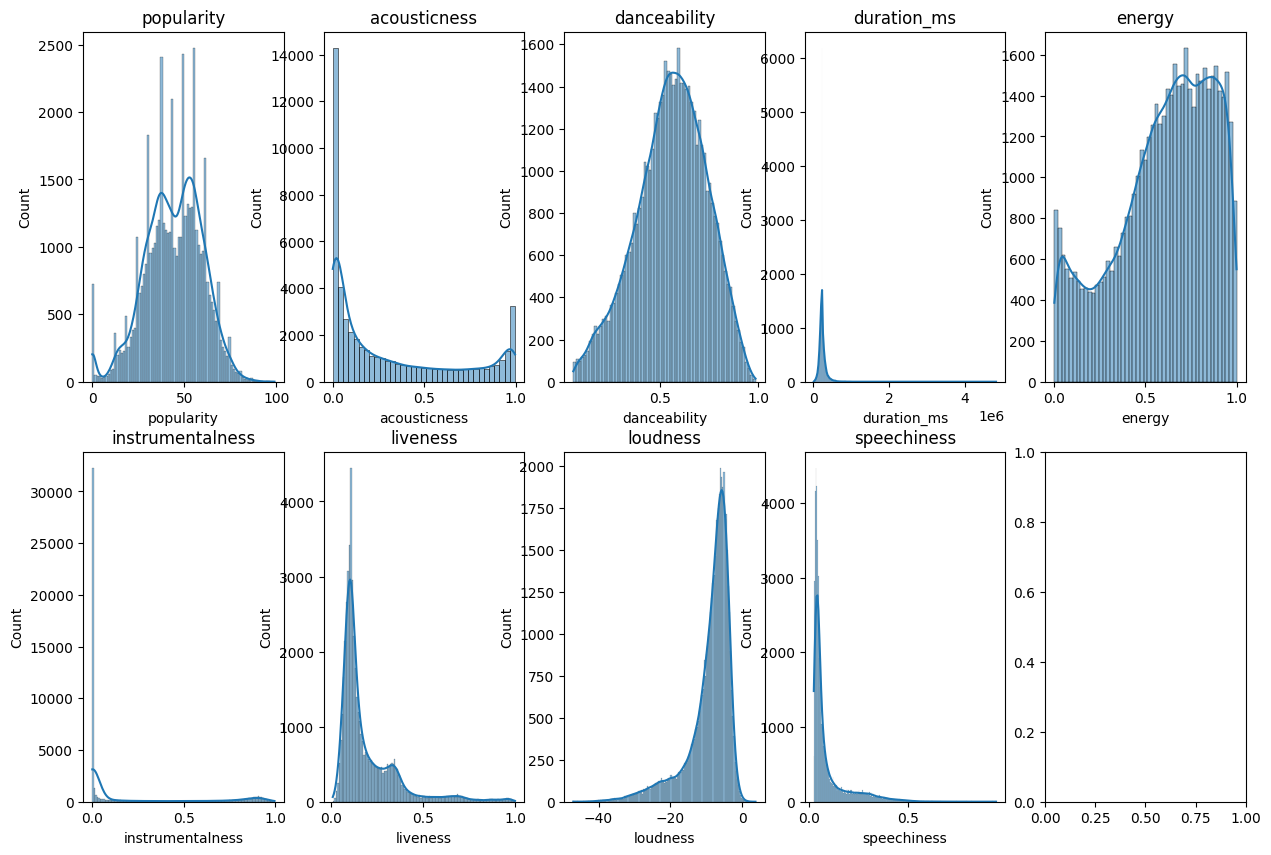

In [14]:
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(15, 10))

for i, numeric_column in enumerate(numeric_columns):
    plt.subplot(2, 5, i + 1)
    sns.histplot(data[numeric_column], kde=True)
    plt.title(numeric_column)

plt.tight_layout()
plt.show()

# Train Test Split and One-Hot Encoding

In [15]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()

unique_genres = data['music_genre'].unique()
for genre in unique_genres:
    # Filter data for the current genre
    genre_data = data[data['music_genre'] == genre]
    
    # Perform random sampling for the test set
    genre_test = genre_data.sample(n=500)  # Use a fixed random state for reproducibility
    
    # Select the rest for the training set
    genre_train = genre_data.drop(genre_test.index)
    
    # Append to the overall training and testing sets
    train_set = pd.concat([train_set, genre_train])
    test_set = pd.concat([test_set, genre_test])
    
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Print the shapes as a check
print("Training Set Shape:", train_set.shape)
print("Testing Set Shape:", test_set.shape)

Training Set Shape: (45000, 15)
Testing Set Shape: (5000, 15)


### Standardize Numerical Features

In [16]:
scaler = StandardScaler()
train_set[numeric_columns] = scaler.fit_transform(train_set[numeric_columns])
test_set[numeric_columns] = scaler.transform(test_set[numeric_columns])

### One-Hot Encode Categorical Features

In [17]:
categorical_columns = ['key', 'mode', 'music_genre','obtained_date']

# One-hot encode these columns
train_set = pd.get_dummies(train_set, columns=categorical_columns)
test_set = pd.get_dummies(test_set, columns=categorical_columns)

train_set, test_set = train_set.align(test_set, join='inner', axis=1)

In [18]:
train_set.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock,obtained_date_1-Apr,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
0,-1.107804,-0.883348,0.523508,-0.154793,1.290431,1.877845,-0.488501,0.638397,-0.186077,-0.655247,...,False,True,False,False,False,False,False,False,True,False
1,-0.850520,-0.859845,0.355592,-0.239609,1.097615,2.363665,-0.432693,0.339365,-0.627289,-0.168823,...,False,True,False,False,False,False,False,False,True,False
2,-1.043483,-0.888096,0.344398,-0.264679,0.587220,-0.521122,2.109670,0.733204,-0.582971,0.278964,...,False,True,False,False,False,False,False,False,True,False
3,-0.786200,-0.883436,0.445147,-0.201481,-0.047939,2.237597,-0.228064,0.465504,-0.516001,0.866340,...,False,True,False,False,False,False,False,False,True,False
4,0.178615,-0.881737,1.100020,2.577707,0.496483,2.068483,0.137788,-0.224607,-0.516986,-0.000730,...,False,True,False,False,False,False,False,False,True,False


In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   popularity               45000 non-null  float64
 1   acousticness             45000 non-null  float64
 2   danceability             45000 non-null  float64
 3   duration_ms              45000 non-null  float64
 4   energy                   45000 non-null  float64
 5   instrumentalness         45000 non-null  float64
 6   liveness                 45000 non-null  float64
 7   loudness                 45000 non-null  float64
 8   speechiness              45000 non-null  float64
 9   tempo                    45000 non-null  float64
 10  valence                  45000 non-null  float64
 11  key_A                    45000 non-null  bool   
 12  key_A#                   45000 non-null  bool   
 13  key_B                    45000 non-null  bool   
 14  key_C                 

In [20]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   popularity               5000 non-null   float64
 1   acousticness             5000 non-null   float64
 2   danceability             5000 non-null   float64
 3   duration_ms              5000 non-null   float64
 4   energy                   5000 non-null   float64
 5   instrumentalness         5000 non-null   float64
 6   liveness                 5000 non-null   float64
 7   loudness                 5000 non-null   float64
 8   speechiness              5000 non-null   float64
 9   tempo                    5000 non-null   float64
 10  valence                  5000 non-null   float64
 11  key_A                    5000 non-null   bool   
 12  key_A#                   5000 non-null   bool   
 13  key_B                    5000 non-null   bool   
 14  key_C                   

# Dimensional Recuduction

In [91]:
tsne = TSNE(n_components=3, perplexity = 45)
train_tsne_3d = tsne.fit_transform(train_set)

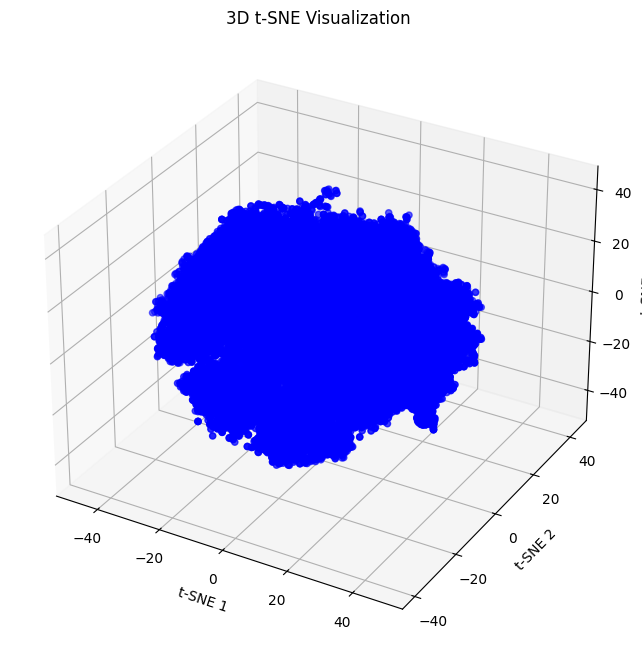

In [92]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], c='blue', marker='o')
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

# Clustering

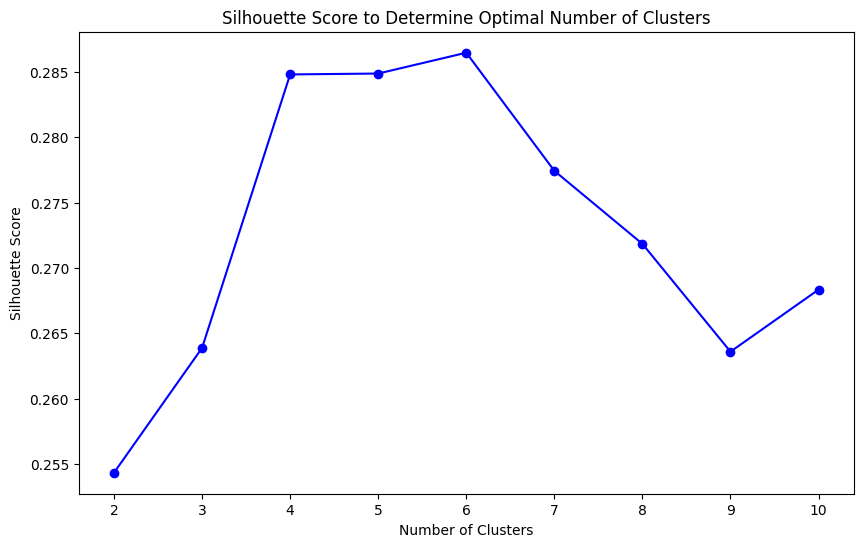

Optimal number of clusters based on silhouette score: 6


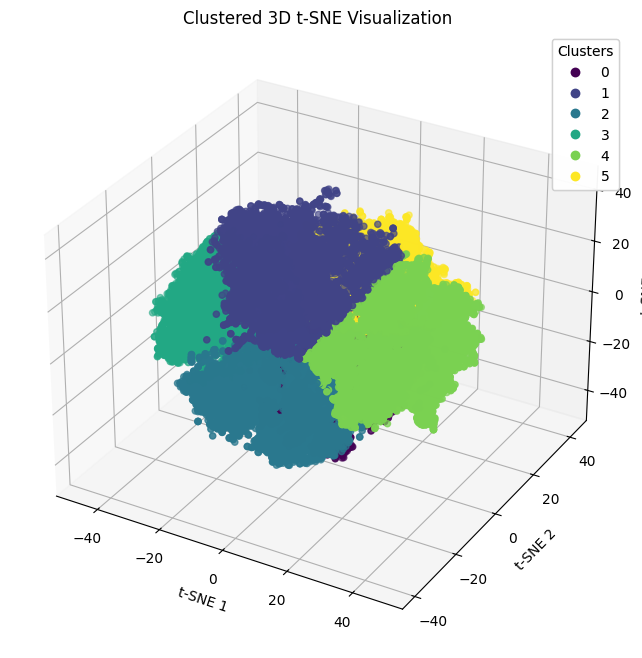

In [93]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o', color='b', linestyle='-')
plt.title('Silhouette Score to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Determine the optimal number of clusters
optimal_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print("Optimal number of clusters based on silhouette score:", optimal_clusters)

kmeans_final = KMeans(n_clusters=optimal_clusters)
cluster_labels_final = kmeans_final.fit_predict(train_tsne_3d)

# Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], c=cluster_labels_final, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('Clustered 3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

In [27]:
genre_columns = [col for col in train_set.columns if col.startswith('music_genre_')]

# Classfication

In [94]:
combined_set = pd.concat([train_set, test_set])

# Apply t-SNE to the combined dataset
#tsne = TSNE(n_components=4, perplexity=30,verbose=2)
combined_tsne = tsne.fit_transform(combined_set.drop(genre_columns, axis=1))  # Assuming genre columns are dropped

# Split the t-SNE results back into train and test
train_tsne_3d = combined_tsne[:len(train_set)]
test_tsne_3d = combined_tsne[len(train_set):]

genre_columns = [col for col in train_set.columns if col.startswith('music_genre_')]
# Extract labels for train and test
y_train = np.argmax(train_set[genre_columns].values, axis=1)
y_test = np.argmax(test_set[genre_columns].values, axis=1)

In [95]:
svm_classifier = SVC(kernel='rbf', C = 25, probability=True, decision_function_shape='ovr') # ovo / ovr
svm_classifier.fit(train_tsne_3d, y_train)

# Since SVM doesn't support multiclass predict_proba directly in the linear kernel with 'ovo', we use decision_function
decision_scores = svm_classifier.decision_function(test_tsne_3d)

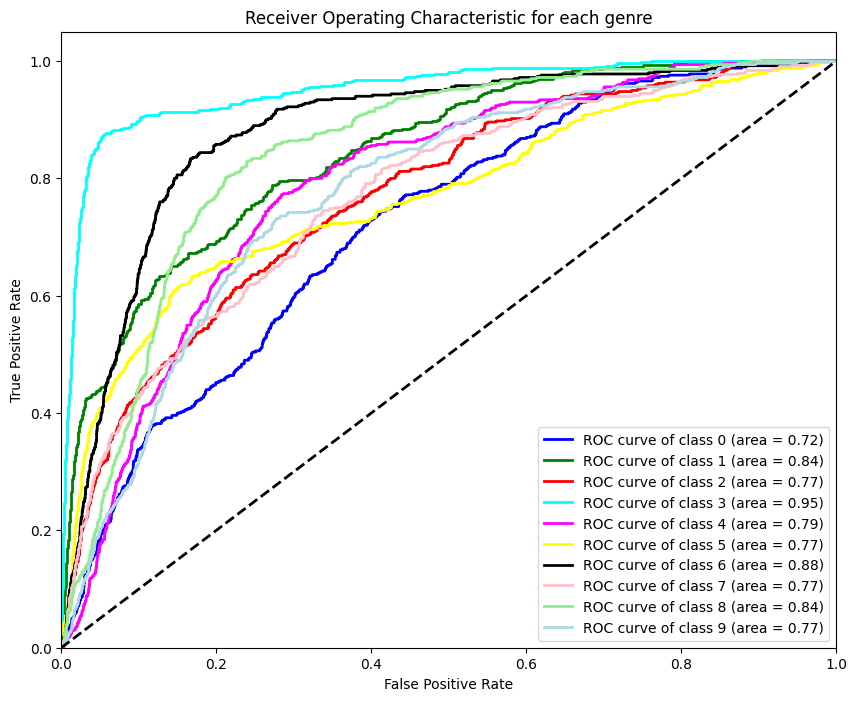

Highest AUC across all genres: 0.8114047555555557
Best AUC: 0.9511186666666667


In [96]:
# ROC and AUC calculations for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(genre_columns)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, decision_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue']
for i, color in zip(range(len(genre_columns)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each genre')
plt.legend(loc="lower right")
plt.show()

average_auc = np.mean(list(roc_auc.values()))
print("Highest AUC across all genres:", average_auc)
# Optionally, report the best AUC
best_auc = max(roc_auc.values())
print("Best AUC:", best_auc)

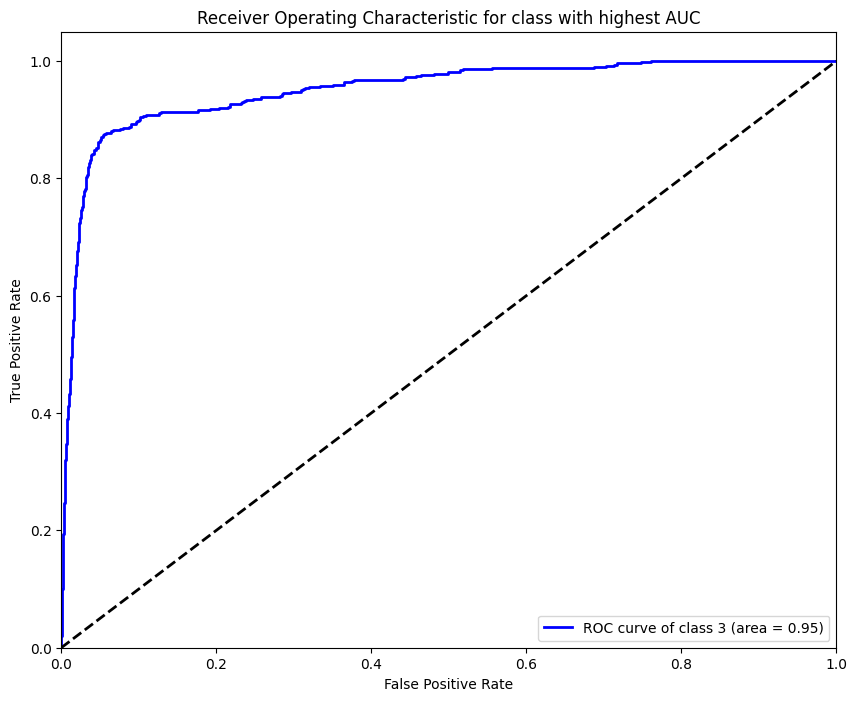

Best AUC for class 3: 0.95


In [97]:
best_class_index = max(roc_auc, key=roc_auc.get)
best_class_auc = roc_auc[best_class_index]

# Plot ROC curve for the class with the highest AUC
plt.figure(figsize=(10, 8))
plt.plot(fpr[best_class_index], tpr[best_class_index], color='blue', lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(best_class_index, best_class_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for class with highest AUC')
plt.legend(loc="lower right")
plt.show()

# Optionally, report the best AUC
print("Best AUC for class {0}: {1:0.2f}".format(best_class_index, best_class_auc))